In [3]:
import os
from dotenv import load_dotenv
from typing import *

load_dotenv()

access_key: Optional[str] = os.getenv('ACCESS_KEY')
secret_access_key: Optional[str] = os.getenv('SECRET_ACCESS_KEY')
aws_region: Optional[str] = os.getenv('AWS_REGION')

In [5]:
# https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html to get the 'ACCESS_KEY' and 'SECRET_ACCESS_KEY'
# https://docs.aws.amazon.com/IAM/latest/UserGuide/id_credentials_access-keys.html

In [7]:
import boto3
client = boto3.client('textract', region_name=aws_region, aws_access_key_id=access_key ,aws_secret_access_key=secret_access_key)

In [11]:
def create_directories(directories: List[str]) -> None:
    for directory in directories:
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Directory '{directory}' created.")
        else:
            print(f"Directory '{directory}' already exists.")

directories: List[str] = ['input', 'output', 'log', 'aws_log']

create_directories(directories)

Directory 'input' already exists.
Directory 'output' already exists.
Directory 'log' already exists.
Directory 'aws_log' already exists.


In [13]:
#input directory -> the pdf file should be in the input 
#output directory -> the pdf extracted is going to be in the output folder
#log directory -> used for intermediate steps
#aws_log -> to store the api output 

In [15]:
pdf_fileName: str = "pdf1.pdf" #this is inside the input directory

In [19]:
from pdf2image import convert_from_path
from PIL import Image

input_dir: str = 'input'
log_dir: str = 'log'
pdf_fileName: str = "pdf1.pdf"

pdf_path: str = os.path.join(input_dir, pdf_fileName)

output_dir: str = os.path.join(log_dir, pdf_fileName.replace('.pdf', ''))

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

pages: List[Image.Image] = convert_from_path(pdf_path)

for i, page in enumerate(pages):
    output_path: str = os.path.join(output_dir, f'{i + 1}.png')
    if os.path.exists(output_path):
        print(f"File already exists, skipping: {output_path}")
        continue
    page.save(output_path, 'PNG')
    print(f"Saved: {output_path}")

File already exists, skipping: log/pdf1/1.png
File already exists, skipping: log/pdf1/2.png
File already exists, skipping: log/pdf1/3.png
File already exists, skipping: log/pdf1/4.png
File already exists, skipping: log/pdf1/5.png
File already exists, skipping: log/pdf1/6.png
File already exists, skipping: log/pdf1/7.png
File already exists, skipping: log/pdf1/8.png
File already exists, skipping: log/pdf1/9.png
File already exists, skipping: log/pdf1/10.png
File already exists, skipping: log/pdf1/11.png
File already exists, skipping: log/pdf1/12.png
File already exists, skipping: log/pdf1/13.png
File already exists, skipping: log/pdf1/14.png
File already exists, skipping: log/pdf1/15.png


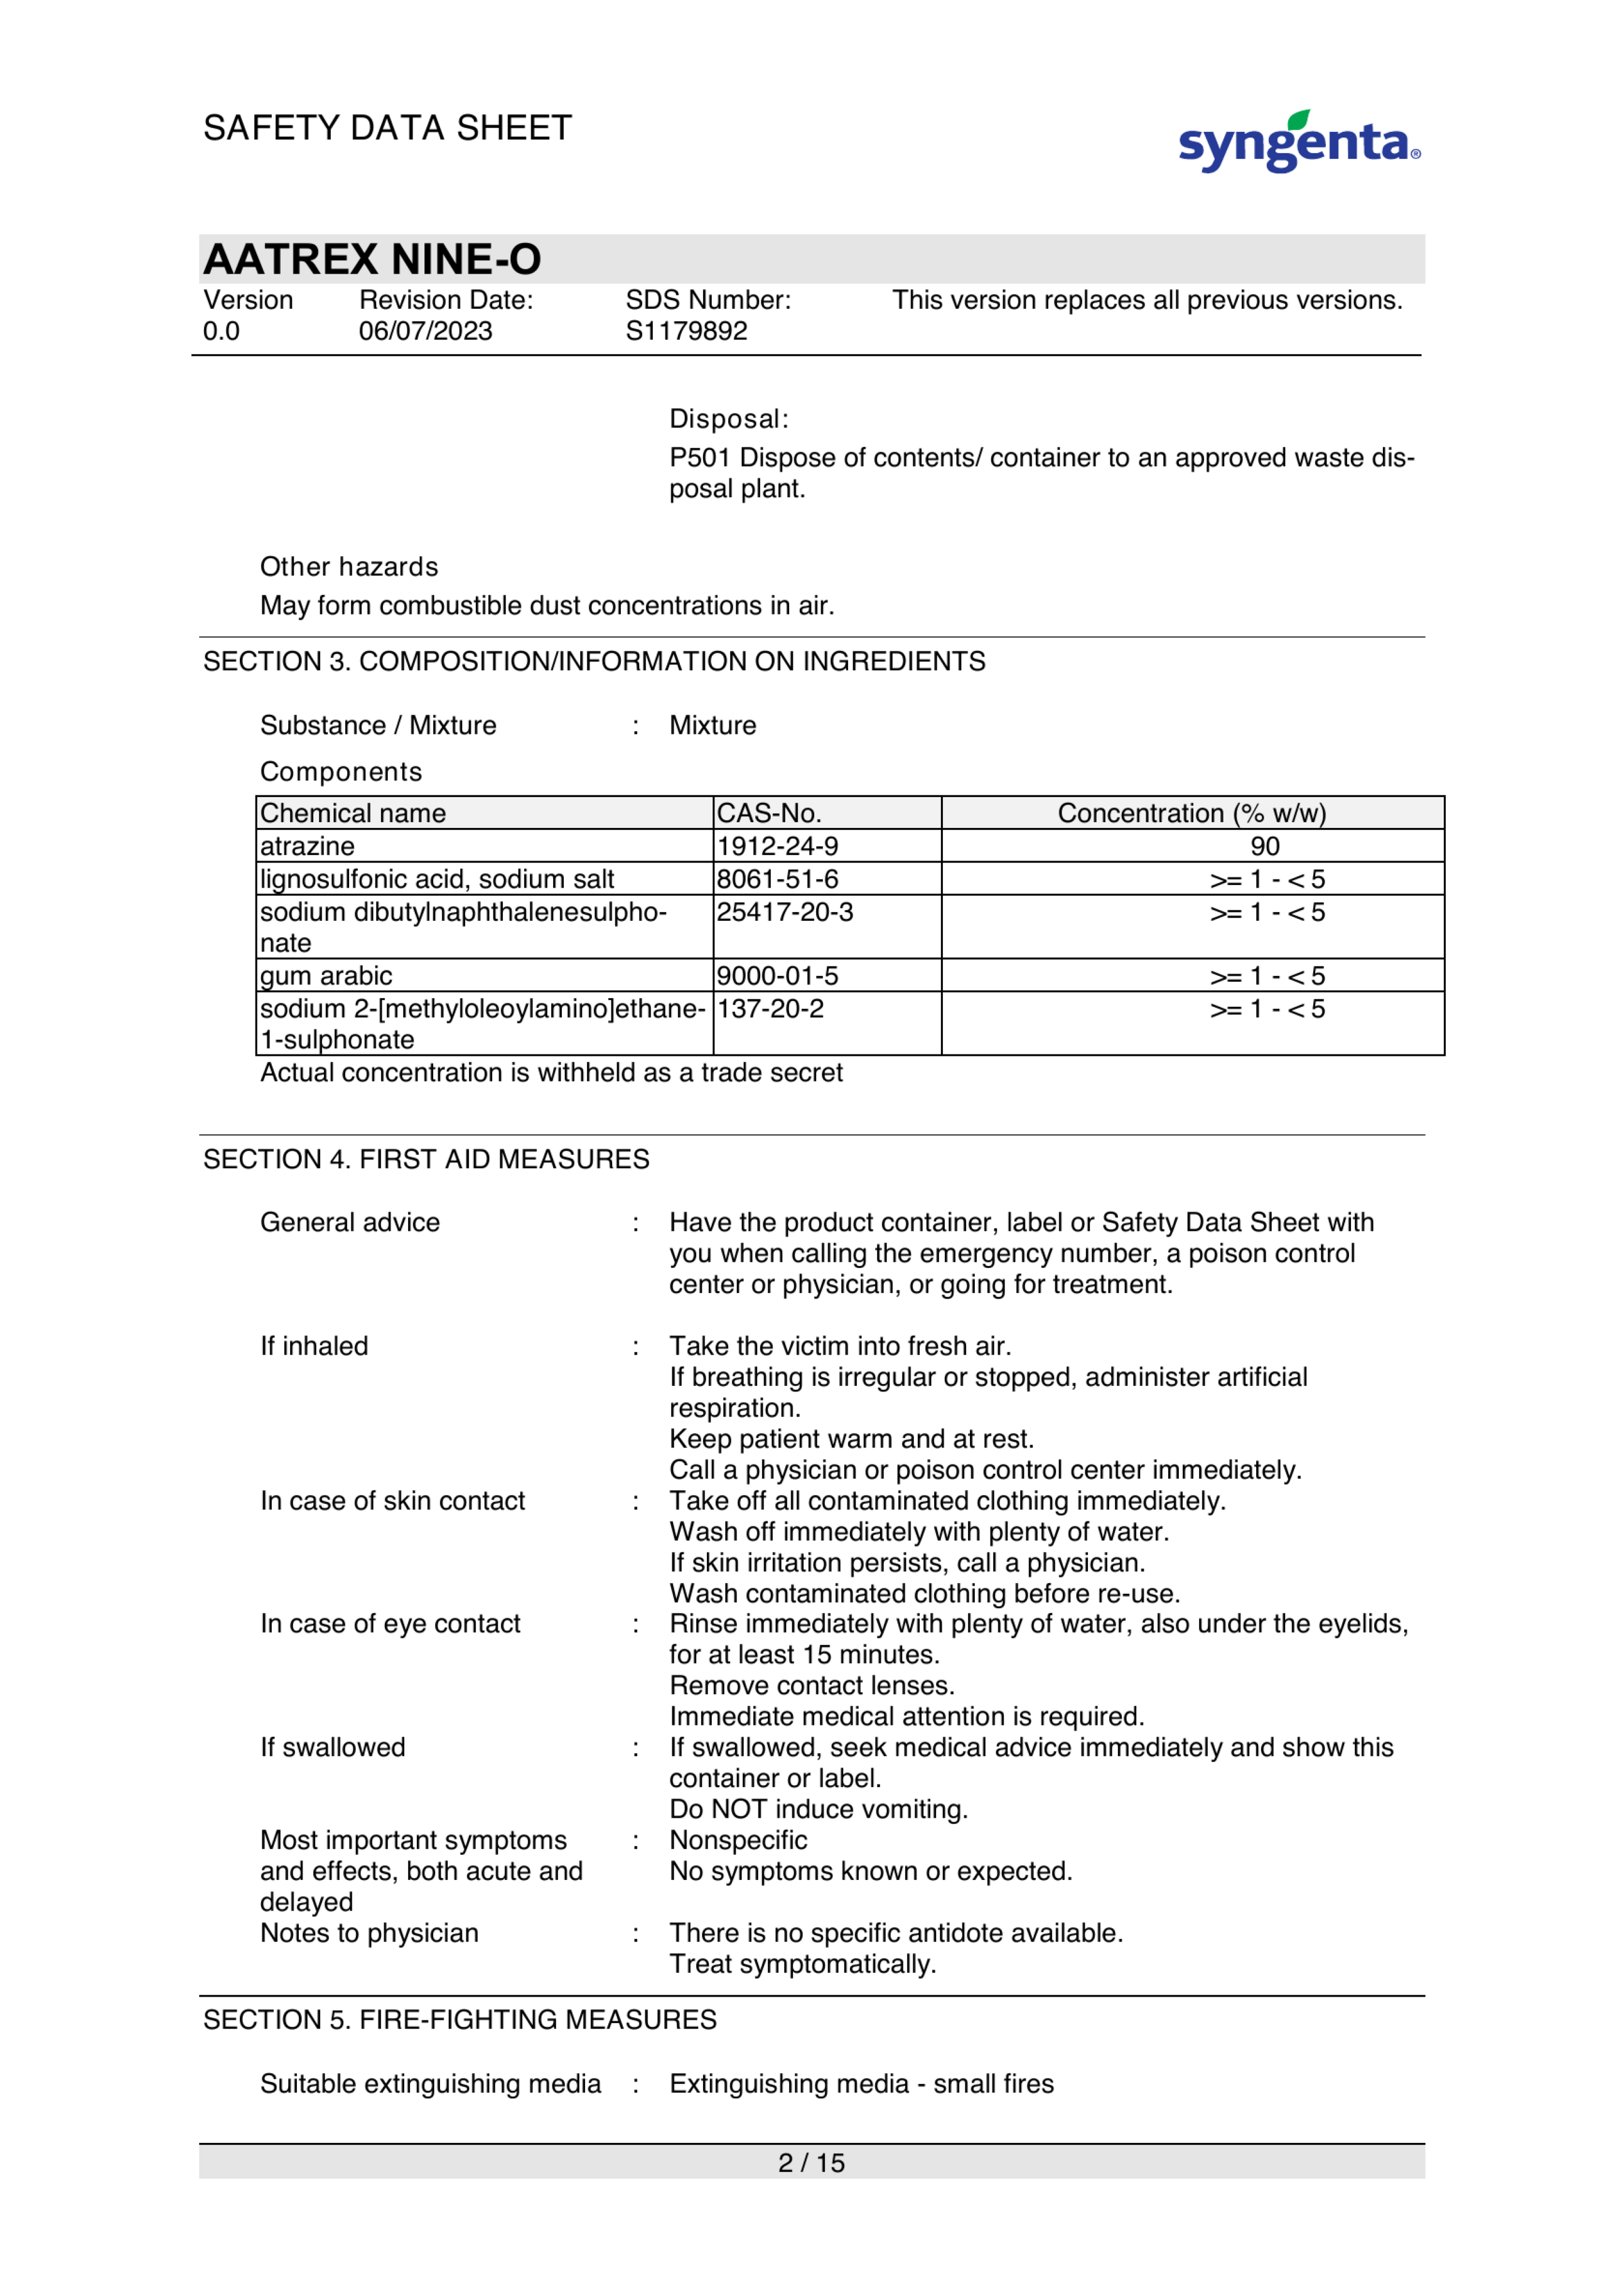

In [21]:
#displaying the second image 

import matplotlib.pyplot as plt

output_dir: str = os.path.join(log_dir, pdf_fileName.replace('.pdf', ''))
image_path: str = os.path.join(output_dir, '2.png')

img: Optional[Image.Image] = Image.open(image_path)

plt.figure(figsize=(img.width / 100, img.height / 100), dpi=200)
plt.imshow(img)
plt.axis('off')
plt.show()

In [25]:
import os
import json
from PIL import Image

def get_response(
    pdf_fileName: str,
    client: Any,
    output_dir: str,
    aws_log: str = "aws_log",
    extract_images: bool = False
) -> None:
    pdf_filename_without_ext: str = os.path.splitext(pdf_fileName)[0]
    aws_log_dir: str = os.path.join(aws_log, pdf_filename_without_ext)

    os.makedirs(aws_log_dir, exist_ok=True)
    png_files = sorted(os.listdir(output_dir), key=lambda x: int(os.path.splitext(x)[0]) if x.endswith(".png") else x)

    for png_file in png_files:
        if png_file.endswith(".png"):
            page_number: str = os.path.splitext(png_file)[0]
            json_file_path: str = os.path.join(aws_log_dir, f"{page_number}.json")

            if os.path.exists(json_file_path):
                print(f"JSON already exists for {png_file}, skipping API call.")
                continue

            png_file_path: str = os.path.join(output_dir, png_file)

            with open(png_file_path, 'rb') as file:
                img_data: bytes = file.read()
                bytes_data: bytearray = bytearray(img_data)

            response: Any = client.analyze_document(Document={'Bytes': bytes_data}, FeatureTypes=['TABLES', 'FORMS'])

            with open(json_file_path, 'w') as json_file:
                json.dump(response, json_file)

            print(f"Saved Textract response for {png_file} as {json_file_path}")

            if extract_images:
                extract_images_from_png(png_file_path, aws_log_dir, page_number)

def extract_images_from_png(png_file_path: str, aws_log_dir: str, page_number: str) -> None:
    img: Image.Image = Image.open(png_file_path)

    image_output_dir: str = os.path.join(aws_log_dir, "images")
    os.makedirs(image_output_dir, exist_ok=True)

    image_save_path: str = os.path.join(image_output_dir, f"{page_number}_image.png")
    img.save(image_save_path)

    print(f"Saved extracted image for {png_file_path} as {image_save_path}")


In [29]:
get_response(pdf_fileName, client, output_dir)

JSON already exists for 1.png, skipping API call.
JSON already exists for 2.png, skipping API call.
JSON already exists for 3.png, skipping API call.
JSON already exists for 4.png, skipping API call.
JSON already exists for 5.png, skipping API call.
JSON already exists for 6.png, skipping API call.
JSON already exists for 7.png, skipping API call.
JSON already exists for 8.png, skipping API call.
JSON already exists for 9.png, skipping API call.
JSON already exists for 10.png, skipping API call.
JSON already exists for 11.png, skipping API call.
JSON already exists for 12.png, skipping API call.
JSON already exists for 13.png, skipping API call.
JSON already exists for 14.png, skipping API call.
JSON already exists for 15.png, skipping API call.


## Testing one page

In [39]:
def read_json_for_page(pdf_fileName: str, page_number: int, aws_log: str = "aws_log") -> Optional[Dict[str, Any]]:
    pdf_filename_without_ext: str = os.path.splitext(pdf_fileName)[0]
    json_file_path: str = os.path.join(aws_log, pdf_filename_without_ext, f"{page_number}.json")

    if os.path.exists(json_file_path):
        with open(json_file_path, 'r') as json_file:
            response: Dict[str, Any] = json.load(json_file)
            return response
    else:
        print(f"JSON file for page {page_number} does not exist.")
        return None

In [41]:
#getting Reponse with a page that has tables 
page_number: int = 2
response: Optional[Dict[str, Any]] = read_json_for_page(pdf_fileName, page_number)

In [43]:
def textract_tables(response: Dict[str, Any]) -> List[List[List[str]]]:
    blocks_map: Dict[str, Any] = {block['Id']: block for block in response['Blocks']}
    tables: List[List[List[str]]] = []

    for block in response['Blocks']:
        if block['BlockType'] == 'TABLE':
            table: List[List[Optional[str]]] = []
            if 'Relationships' in block:
                for relationship in block['Relationships']:
                    if relationship['Type'] == 'CHILD':
                        for cell_id in relationship['Ids']:
                            cell_block = blocks_map[cell_id]
                            if cell_block['BlockType'] == 'CELL':
                                cell_text: str = " ".join(
                                    [blocks_map[child_id]['Text'] for cell_rel in cell_block.get('Relationships', [])
                                     if cell_rel['Type'] == 'CHILD'
                                     for child_id in cell_rel['Ids']
                                     if blocks_map[child_id]['BlockType'] == 'WORD']
                                ).strip()
                                row_index, col_index = cell_block['RowIndex'], cell_block['ColumnIndex']
                                while len(table) < row_index:
                                    table.append([])
                                while len(table[row_index - 1]) < col_index:
                                    table[row_index - 1].append(None)
                                table[row_index - 1][col_index - 1] = cell_text
            tables.append(table)

    return tables

tables: List[List[List[str]]] = textract_tables(response)

for table in tables:
    print("Extracted Table:")
    for row in table:
        print(row)

Extracted Table:
['Chemical name', 'CAS-No.', 'Concentration (% w/w)']
['atrazine', '1912-24-9', '90']
['lignosulfonic acid, sodium salt', '8061-51-6', '>=1-<5']
['sodium dibutylnaphthalenesulpho- nate', '25417-20-3', '>=1-<5']
['gum arabic', '9000-01-5', '>=1-<5']
['sodium 2-[methyloleoylamino]ethane- 1-sulphonate', '137-20-2', '>=1-<5']
Extracted Table:
['General advice', ': Have the product container, label or Safety Data Sheet with you when calling the emergency number, a poison control center or physician, or going for treatment.']
['If inhaled', ': Take the victim into fresh air. If breathing is irregular or stopped, administer artificial respiration. Keep patient warm and at rest. Call a physician or poison control center immediately.']
['In case of skin contact', ': Take off all contaminated clothing immediately. Wash off immediately with plenty of water. If skin irritation persists, call a physician. Wash contaminated clothing before re-use.']
['In case of eye contact', ': Rin

In [45]:
import pandas as pd
from IPython.display import display

def display_extracted_tables(tables: List[List[List[Optional[str]]]]) -> None:
    [print(f"Extracted Table_{i + 1}:") or display(pd.DataFrame(table)) for i, table in enumerate(tables)]

display_extracted_tables(tables)

Extracted Table_1:


,0,1,2
0,Chemical name,CAS-No.,Concentration (% w/w)
1,atrazine,1912-24-9,90
2,"lignosulfonic acid, sodium salt",8061-51-6,>=1-<5
3,sodium dibutylnaphthalenesulpho- nate,25417-20-3,>=1-<5
4,gum arabic,9000-01-5,>=1-<5
5,sodium 2-[methyloleoylamino]ethane- 1-sulphonate,137-20-2,>=1-<5


Extracted Table_2:


,0,1
0,General advice,": Have the product container, label or Safety ..."
1,If inhaled,: Take the victim into fresh air. If breathing...
2,In case of skin contact,: Take off all contaminated clothing immediate...
3,In case of eye contact,": Rinse immediately with plenty of water, also..."
4,If swallowed,": If swallowed, seek medical advice immediatel..."
5,"Most important symptoms and effects, both acut...",: Nonspecific No symptoms known or expected.
6,Notes to physician,: There is no specific antidote available. Tre...


In [49]:
from typing import List, Dict, Any
from IPython.display import display, HTML

def textract_tables_to_HTML(response: Dict[str, Any]) -> str:
    tables: List[List[List[str]]] = []
    blocks_dict: Dict[str, Any] = {block['Id']: block for block in response['Blocks']}

    for block in response['Blocks']:
        if block['BlockType'] == 'TABLE':
            current_table: List[List[Optional[str]]] = []

            if 'Relationships' in block:
                for relationship in block['Relationships']:
                    if relationship['Type'] == 'CHILD':
                        for cell_id in relationship['Ids']:
                            cell_block = blocks_dict[cell_id]
                            if cell_block['BlockType'] == 'CELL':
                                cell_content: str = ""

                                if 'Relationships' in cell_block:
                                    for cell_relationship in cell_block['Relationships']:
                                        if cell_relationship['Type'] == 'CHILD':
                                            for word_id in cell_relationship['Ids']:
                                                word_block = blocks_dict[word_id]
                                                if word_block['BlockType'] == 'WORD':
                                                    cell_content += word_block['Text'] + " "

                                row_idx: int = cell_block['RowIndex']
                                col_idx: int = cell_block['ColumnIndex']

                                while len(current_table) < row_idx:
                                    current_table.append([])

                                while len(current_table[row_idx - 1]) < col_idx:
                                    current_table[row_idx - 1].append(None)

                                current_table[row_idx - 1][col_idx - 1] = cell_content.strip()

            tables.append(current_table)

    html_result: str = ""
    table_counter: int = 1
    for tbl in tables:
        html_result += f"<h3>Table {table_counter}</h3>"
        html_result += "<table border='1'>"
        for row in tbl:
            html_result += "<tr>"
            for cell in row:
                html_result += f"<td>{cell or ''}</td>"
            html_result += "</tr>"
        html_result += "</table><br>"
        table_counter += 1

    return html_result


html_output: str = textract_tables_to_HTML(response)
display(HTML(html_output))


## Image Extraction

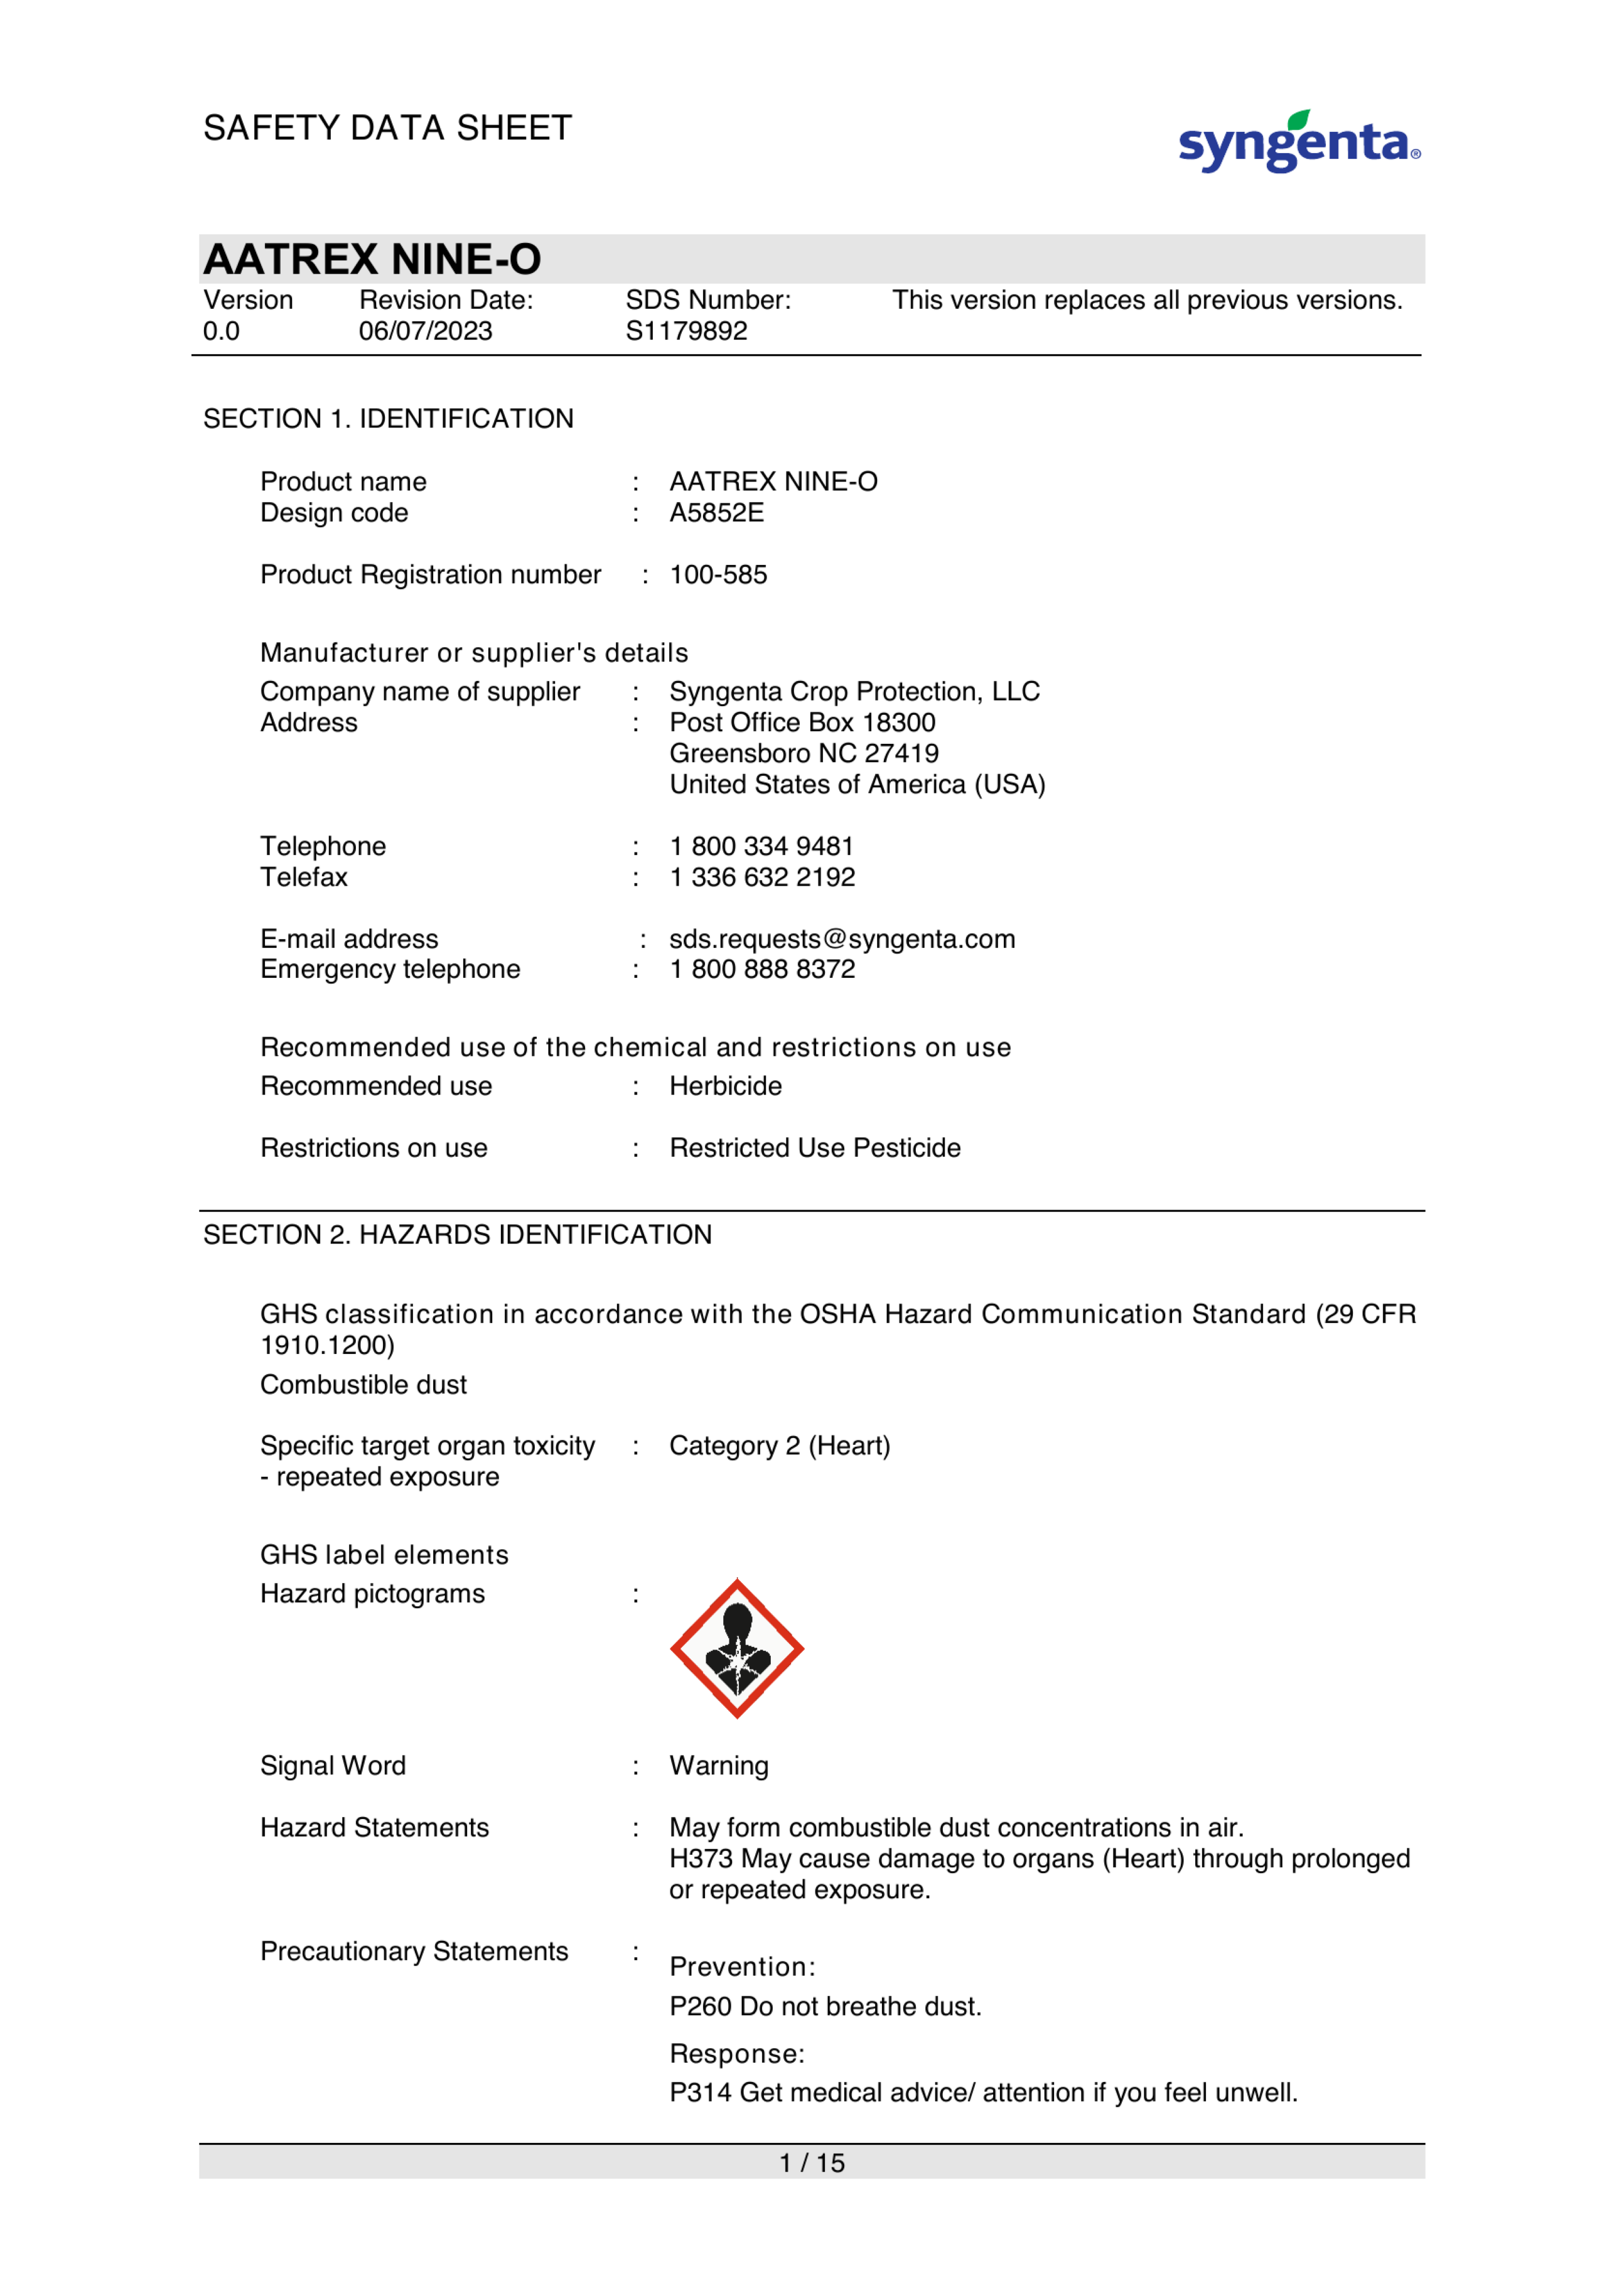

In [55]:
#displaying the first image 

import matplotlib.pyplot as plt
from PIL import Image

output_dir: str = os.path.join(log_dir, pdf_fileName.replace('.pdf', ''))
image_path: str = os.path.join(output_dir, '1.png')

img: Optional[Image.Image] = Image.open(image_path)

plt.figure(figsize=(img.width / 100, img.height / 100), dpi=200)
plt.imshow(img)
plt.axis('off')
plt.show()

In [59]:
import cv2
import numpy as np

def extract_image_regions(png_path: str, output_dir: str) -> int:
    base_name: str = os.path.basename(png_path).replace('.png', '')

    image: Optional[np.ndarray] = cv2.imread(png_path)
    gray: Optional[np.ndarray] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)  # no need to annotate here
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    image_count: int = 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        if w > 100 and h > 100:  
            image_region: Optional[np.ndarray] = image[y:y+h, x:x+w]

            output_path: str = os.path.join(output_dir, f"{base_name}_{image_count + 1}.png")
            cv2.imwrite(output_path, image_region)
            image_count += 1
    
    print(f"Extracted {image_count} images from {png_path}")
    return image_count

png_file: str = 'log/pdf1/1.png'
pdf_base: str = 'pdf1'
output_directory: str = os.path.join('extracted_images', pdf_base)

extract_image_regions(png_file, output_directory)


Extracted 1 images from log/pdf1/1.png


1

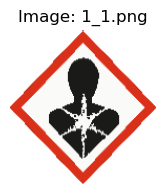

In [63]:
def display_extracted_images(output_dir: str) -> None:
    image_files: List[str] = sorted([f for f in os.listdir(output_dir) if f.endswith('.png')])

    for image_file in image_files:
        image_path: str = os.path.join(output_dir, image_file)
        image = cv2.imread(image_path)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(2, 2))
        plt.imshow(rgb_image)
        plt.axis('off')
        plt.title(f"Image: {image_file}")
        plt.show()

output_directory: str = os.path.join('extracted_images', 'pdf1')
display_extracted_images(output_directory)

# Text Extraction for a given page

In [65]:
from collections import defaultdict

def get_text(response: Dict[str, Any]) -> str:

    def extract_table_cells(block_map: Dict[str, Any], table_block: Dict[str, Any]) -> List[List[str]]:
        table_data = []
        for relationship in table_block.get('Relationships', []):
            if relationship['Type'] == 'CHILD':
                for cell_id in relationship['Ids']:
                    cell_block = block_map[cell_id]
                    if cell_block['BlockType'] == 'CELL':
                        text = " ".join(
                            block_map[child_id]['Text']
                            for child_relation in cell_block.get('Relationships', [])
                            if child_relation['Type'] == 'CHILD'
                            for child_id in child_relation['Ids']
                            if block_map[child_id]['BlockType'] == 'WORD'
                        )
                        row_idx, col_idx = cell_block['RowIndex'], cell_block['ColumnIndex']
                        while len(table_data) < row_idx:
                            table_data.append([])
                        while len(table_data[row_idx - 1]) < col_idx:
                            table_data[row_idx - 1].append(None)
                        table_data[row_idx - 1][col_idx - 1] = text.strip()
        return table_data

    def is_bbox_overlapping(bbox1: Dict[str, float], bbox2: Dict[str, float]) -> bool:
        return not (
            bbox1['Left'] >= bbox2['Left'] + bbox2['Width'] or
            bbox2['Left'] >= bbox1['Left'] + bbox1['Width'] or
            bbox1['Top'] >= bbox2['Top'] + bbox2['Height'] or
            bbox2['Top'] >= bbox1['Top'] + bbox1['Height']
        )

    def is_title_block(line_block: Dict[str, Any], max_height: float, top_threshold: float) -> bool:
        bbox = line_block['Geometry']['BoundingBox']
        return bbox['Height'] >= max_height * 0.9 and bbox['Top'] <= top_threshold

    block_map = {block['Id']: block for block in response['Blocks']}
    table_bboxes = [block['Geometry']['BoundingBox'] for block in response['Blocks'] if block['BlockType'] == 'TABLE']

    block_positions = []
    line_heights = []
    max_height = 0

    for block in response['Blocks']:
        if block['BlockType'] in ['LINE', 'TABLE']:
            bbox = block['Geometry']['BoundingBox']
            block_positions.append({
                'Type': block['BlockType'],
                'Top': bbox['Top'],
                'Left': bbox['Left'],
                'Block': block,
                'BBox': bbox
            })
            if block['BlockType'] == 'LINE':
                line_heights.append(bbox['Height'])
                max_height = max(max_height, bbox['Height'])

    def cluster_left_positions(data: List[float], k: int = 2) -> List[float]:
        centroids = [min(data), max(data)]
        for _ in range(100):
            clusters = [[val for val in data if abs(val - c) == min(abs(val - c) for c in centroids)] for c in centroids]
            new_centroids = [sum(cluster) / len(cluster) if cluster else centroids[i] for i, cluster in enumerate(clusters)]
            if new_centroids == centroids:
                break
            centroids = new_centroids
        return centroids

    centroids = cluster_left_positions([block['Left'] for block in block_positions])
    for block in block_positions:
        block['Col'] = min(range(2), key=lambda i: abs(block['Left'] - centroids[i]))

    columns = defaultdict(list)
    for block in block_positions:
        columns[block['Col']].append(block)

    for column_blocks in columns.values():
        column_blocks.sort(key=lambda block: block['Top'])

    title_found = False
    extracted_text = []
    sorted_centroid_indices = sorted(range(len(centroids)), key=lambda i: centroids[i])

    for idx in sorted_centroid_indices:
        column_blocks = columns[idx]
        for block in column_blocks:
            if block['Type'] == 'LINE':
                line_bbox = block['BBox']
                if not any(is_bbox_overlapping(line_bbox, table_bbox) for table_bbox in table_bboxes):
                    if not title_found and is_title_block(block['Block'], max_height, 0.2):
                        extracted_text.append(f"{block['Block']['Text']} {{['TITLE']}}")
                        title_found = True
                    else:
                        extracted_text.append(block['Block']['Text'])
            elif block['Type'] == 'TABLE':
                table = extract_table_cells(block_map, block['Block'])
                extracted_text.append("{['TABLE']}")
                extracted_text.extend([str(row) for row in table])

    return "\n".join(extracted_text)


In [67]:
print(get_text(response))

SAFETY DATA SHEET
AATREX NINE-O
Revision Date:
SDS Number:
Version
S1179892
06/07/2023
0.0
Disposal:
P501 Dispose of contents/ container to an approved waste dis-
posal plant.
Other hazards
May form combustible dust concentrations in air.
SECTION 3. COMPOSITION/INFORMATION ON INGREDIENTS
Substance / Mixture
: Mixture
Components
{['TABLE']}
['Chemical name', 'CAS-No.', 'Concentration (% w/w)']
['atrazine', '1912-24-9', '90']
['lignosulfonic acid, sodium salt', '8061-51-6', '>=1-<5']
['sodium dibutylnaphthalenesulpho- nate', '25417-20-3', '>=1-<5']
['gum arabic', '9000-01-5', '>=1-<5']
['sodium 2-[methyloleoylamino]ethane- 1-sulphonate', '137-20-2', '>=1-<5']
Actual concentration is withheld as a trade secret
SECTION 4. FIRST AID MEASURES
{['TABLE']}
['General advice', ': Have the product container, label or Safety Data Sheet with you when calling the emergency number, a poison control center or physician, or going for treatment.']
['If inhaled', ': Take the victim into fresh air. If bre